In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

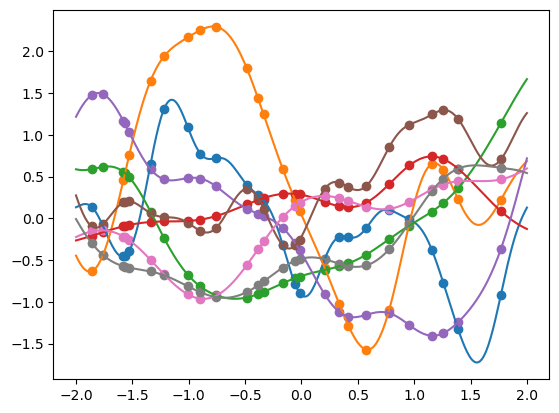

In [37]:
from data.datasets2 import GPData
import matplotlib.pyplot as plt

dataset = GPData(max_num_context=97)

batch = dataset.generate_batch(batch_size=8, testing=True)
for i in range(8):
    x_target = batch.x_target[i].flatten()
    y_target = batch.y_target[i].flatten()
    plt.plot(x_target, y_target)
for i in range(8):
    x_context = batch.x_context[i].flatten()
    y_context = batch.y_context[i].flatten()
    plt.scatter(x_context, y_context)
plt.show()

NeuralProcess(
  (latent_encoder): LatentEncoder(
    (phi): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU()
        (4): Linear(in_features=50, out_features=50, bias=True)
        (5): Identity()
      )
    )
    (rho): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=100, bias=True)
        (3): Identity()
      )
    )
  )
  (decoder): Decoder(
    (target_transform): Linear(in_features=1, out_features=50, bias=True)
    (decoder): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=100, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU()
        (4): Linear(in_features=50, out_features=50, bias=True)
        (5): ReLU()

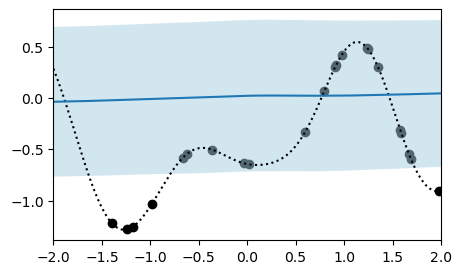

iter 1001: Avg. Loss = 54.089444202423095
iter 2001: Avg. Loss = 40.299978239655495
iter 3001: Avg. Loss = 38.93780588436127
iter 4001: Avg. Loss = 38.45759492170811
iter 5001: Avg. Loss = 38.247628090023994
iter 6001: Avg. Loss = 37.18703586256504
iter 7001: Avg. Loss = 38.04740505871177
iter 8001: Avg. Loss = 37.3526250474453
iter 9001: Avg. Loss = 38.15894591403008
iter 10001: Avg. Loss = 38.23563523030281
iter 10001: Avg. Loss SLOW = 399.01409845122697
iter 11001: Avg. Loss = 37.83893816125393
iter 12001: Avg. Loss = 37.07972539758682
iter 13001: Avg. Loss = 38.33251662826538
iter 14001: Avg. Loss = 36.9080356413126
iter 15001: Avg. Loss = 37.77726851415634
iter 16001: Avg. Loss = 36.87856472611427
iter 17001: Avg. Loss = 37.441881565332416
iter 18001: Avg. Loss = 37.338827339410784
iter 19001: Avg. Loss = 36.82706701822579
iter 20001: Avg. Loss = 36.01976496624947
iter 20001: Avg. Loss SLOW = 372.4425899579078


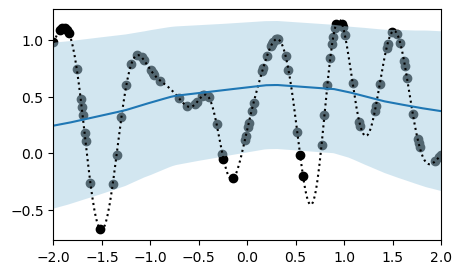

iter 21001: Avg. Loss = 36.077025617361066
iter 22001: Avg. Loss = 37.29323879122734
iter 23001: Avg. Loss = 35.750804293558005
iter 24001: Avg. Loss = 33.053682588279244
iter 25001: Avg. Loss = 30.855215536385774
iter 26001: Avg. Loss = 30.74167926056683
iter 27001: Avg. Loss = 30.45994171586633
iter 28001: Avg. Loss = 30.09274172323942
iter 29001: Avg. Loss = 31.278800618693232
iter 30001: Avg. Loss = 29.04529928971827
iter 30001: Avg. Loss SLOW = 324.6484294348955
iter 31001: Avg. Loss = 29.652474146410825
iter 32001: Avg. Loss = 29.625709652125835
iter 33001: Avg. Loss = 29.6454927829206
iter 34001: Avg. Loss = 29.36690564508736
iter 35001: Avg. Loss = 29.86493707165122
iter 36001: Avg. Loss = 28.841547050714492
iter 37001: Avg. Loss = 29.380036277383567
iter 38001: Avg. Loss = 29.587625683009623
iter 39001: Avg. Loss = 29.215336496323346
iter 40001: Avg. Loss = 28.991195277318358
iter 40001: Avg. Loss SLOW = 294.17126008294525


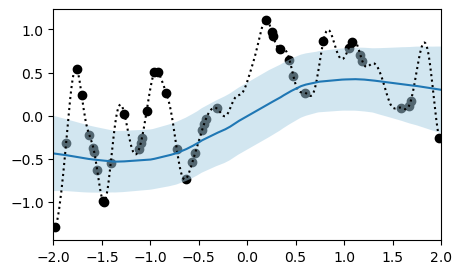

iter 41001: Avg. Loss = 29.60829592692107
iter 42001: Avg. Loss = 28.786674722373487
iter 43001: Avg. Loss = 28.019209505051375
iter 44001: Avg. Loss = 29.31414574611187
iter 45001: Avg. Loss = 29.966968014597892
iter 46001: Avg. Loss = 28.783732235163452
iter 47001: Avg. Loss = 28.305052055492997
iter 48001: Avg. Loss = 29.077391959667207
iter 49001: Avg. Loss = 28.330699604988098
iter 50001: Avg. Loss = 28.201818682223557
iter 50001: Avg. Loss SLOW = 288.393988452591
iter 51001: Avg. Loss = 27.087383883770556
iter 52001: Avg. Loss = 24.757019347816705
iter 53001: Avg. Loss = 23.4917183701694
iter 54001: Avg. Loss = 22.576667429417373
iter 55001: Avg. Loss = 22.06897266073525
iter 56001: Avg. Loss = 22.193755259662865
iter 57001: Avg. Loss = 21.364287782773374
iter 58001: Avg. Loss = 21.16161417646706
iter 59001: Avg. Loss = 21.28462426149845
iter 60001: Avg. Loss = 21.5636254773289
iter 60001: Avg. Loss SLOW = 227.54966864963993


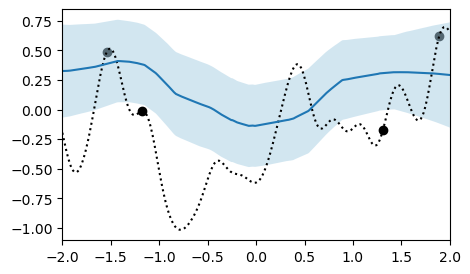

iter 61001: Avg. Loss = 20.90160795468092
iter 62001: Avg. Loss = 20.70846212654561
iter 63001: Avg. Loss = 21.38964597698301
iter 64001: Avg. Loss = 20.505599985457955
iter 65001: Avg. Loss = 20.718774111151696
iter 66001: Avg. Loss = 20.523404490217565
iter 67001: Avg. Loss = 20.59766323699057
iter 68001: Avg. Loss = 20.84319141548872
iter 69001: Avg. Loss = 20.417617759034037
iter 70001: Avg. Loss = 20.701864703446628
iter 70001: Avg. Loss SLOW = 207.3078317599967
iter 71001: Avg. Loss = 20.515218410342932
iter 72001: Avg. Loss = 20.57970553511381


KeyboardInterrupt: 

In [46]:
import torch
from src.plot import plot_predictive
from src.np import NeuralProcess

x_dim = 1
y_dim = 1
determ_dim = 50  # Dimension of representation of context points
latent_dim = 50  # Dimension of sampled latent variable
hidden_dim = 50  # Dimension of hidden layers in encoder and decoder
np = NeuralProcess(x_dim=x_dim,
                   y_dim=y_dim,
                   hidden_dim=hidden_dim,
                   latent_dim=latent_dim,
                   determ_dim=determ_dim,
                   n_h_layers_decoder=3,
                   n_h_layers_phi_latent_encoder=2,
                   n_h_layers_rho_latent_encoder=1,
                   n_h_layers_phi_determ_encoder=6,
                   n_h_layers_rho_determ_encoder=0,
                   use_deterministic_path=False)
print(np)
print(sum(p.numel() for p in np.parameters() if p.requires_grad))

#data = SineData(max_num_context=30, random_kernel_parameters=True)
optimiser = torch.optim.Adam(np.parameters(), lr=1e-4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
np.to(device)


data = GPData(max_num_context=97)
train_loss = []
avg_loss_fast = 0
avg_loss_slow = 0
for iter in range(100000+1):
    np.training = True
    optimiser.zero_grad()

    batch = data.generate_batch(batch_size=16, device=device)
    p_y_pred, loss = np(batch.x_context, batch.y_context, batch.x_target, batch.y_target)

    loss.backward()
    optimiser.step()
    train_loss.append(loss.item())

    avg_loss_slow += loss.item()
    avg_loss_fast += loss.item()
    
    if iter % 1000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss = {avg_loss_fast/1000}")
        avg_loss_fast = 0 
    if iter % 10000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss SLOW = {avg_loss_slow/1000}")
        avg_loss_slow = 0 
    if iter % 20000 == 0:
        np.training = False
        batch = data.generate_batch(batch_size=1, testing=True, device=np.device)
        plot_predictive(np, batch, knowledge=None, save=False, iter=None)
        np.training = True

plt.plot(train_loss, label='train_loss')
window = 50
plt.plot([sum(train_loss[i:i+window])/window for i in range(len(train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()

iter 73001: Avg. Loss = 19.772703576743602
iter 74001: Avg. Loss = 20.485372430056334
iter 75001: Avg. Loss = 20.063191890329122
iter 76001: Avg. Loss = 20.94067060483992
iter 77001: Avg. Loss = 20.738650921672583
iter 78001: Avg. Loss = 20.617191413596274
iter 79001: Avg. Loss = 20.987942792080343
iter 80001: Avg. Loss = 19.63308818346262
iter 80001: Avg. Loss SLOW = 204.33373575823754


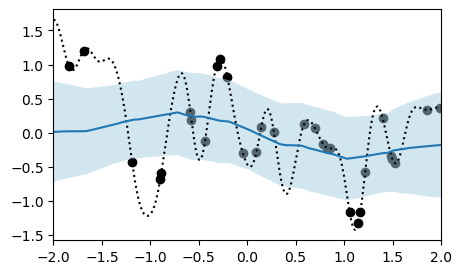

iter 81001: Avg. Loss = 20.666356414973738
iter 82001: Avg. Loss = 20.3551125395298
iter 83001: Avg. Loss = 20.30265655501187
iter 84001: Avg. Loss = 19.704124906271694
iter 85001: Avg. Loss = 20.240531565219165
iter 86001: Avg. Loss = 20.352618515715005
iter 87001: Avg. Loss = 20.43457419089973
iter 88001: Avg. Loss = 20.594384430199863
iter 89001: Avg. Loss = 19.19429358863458
iter 90001: Avg. Loss = 19.577277919225395
iter 90001: Avg. Loss SLOW = 201.42193062568083
iter 91001: Avg. Loss = 20.26282273107767
iter 92001: Avg. Loss = 20.19087189862132
iter 93001: Avg. Loss = 19.897806396484373
iter 94001: Avg. Loss = 18.815923898920417
iter 95001: Avg. Loss = 19.278207677543165
iter 96001: Avg. Loss = 19.57756503687799
iter 97001: Avg. Loss = 19.459173714190722
iter 98001: Avg. Loss = 20.39060079282522
iter 99001: Avg. Loss = 19.921910387158395
iter 100001: Avg. Loss = 20.128175201848148
iter 100001: Avg. Loss SLOW = 197.92305773554742


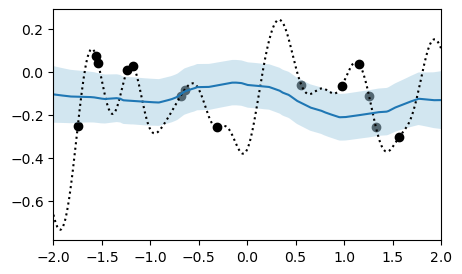

iter 101001: Avg. Loss = 19.31143777577579
iter 102001: Avg. Loss = 19.0262840128541
iter 103001: Avg. Loss = 19.044859790474177
iter 104001: Avg. Loss = 18.753290367767214
iter 105001: Avg. Loss = 19.01021912007034
iter 106001: Avg. Loss = 18.551375583976508
iter 107001: Avg. Loss = 19.465773459911347
iter 108001: Avg. Loss = 18.580470507994296
iter 109001: Avg. Loss = 19.780429057851435
iter 110001: Avg. Loss = 19.235942125082016
iter 110001: Avg. Loss SLOW = 190.76008180175722
iter 111001: Avg. Loss = 19.4490388725847
iter 112001: Avg. Loss = 18.587244611382484
iter 113001: Avg. Loss = 18.934227911755443
iter 114001: Avg. Loss = 18.86948550850153
iter 115001: Avg. Loss = 17.947887126639486
iter 116001: Avg. Loss = 18.028975750371814
iter 117001: Avg. Loss = 18.84402878071368
iter 118001: Avg. Loss = 18.518607040256263
iter 119001: Avg. Loss = 18.660105050312357
iter 120001: Avg. Loss = 18.58867518815957
iter 120001: Avg. Loss SLOW = 186.42827584067732


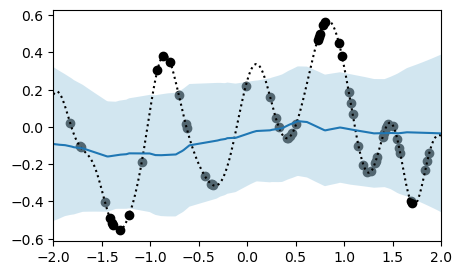

iter 121001: Avg. Loss = 18.171728081554175
iter 122001: Avg. Loss = 18.712806895658375
iter 123001: Avg. Loss = 18.98398011045158
iter 124001: Avg. Loss = 18.50365420310199
iter 125001: Avg. Loss = 18.715354308366777
iter 126001: Avg. Loss = 18.11987096016854
iter 127001: Avg. Loss = 18.229476579621434
iter 128001: Avg. Loss = 18.348670788936317
iter 129001: Avg. Loss = 18.624110402181746
iter 130001: Avg. Loss = 18.49222914277017
iter 130001: Avg. Loss SLOW = 184.9018814728111
iter 131001: Avg. Loss = 17.978167187646033
iter 132001: Avg. Loss = 18.8983874309659
iter 133001: Avg. Loss = 18.376320228777825
iter 134001: Avg. Loss = 18.565815935239197
iter 135001: Avg. Loss = 17.907239521056415
iter 136001: Avg. Loss = 18.066394036453218
iter 137001: Avg. Loss = 18.134632359534503
iter 138001: Avg. Loss = 17.716719836711885
iter 139001: Avg. Loss = 18.309415240451692
iter 140001: Avg. Loss = 18.981388057917357
iter 140001: Avg. Loss SLOW = 182.93447983475403


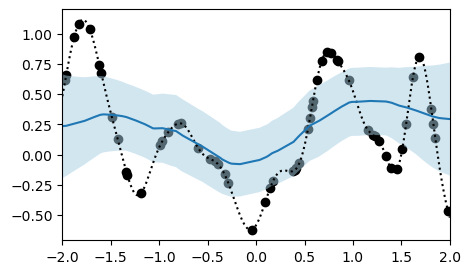

iter 141001: Avg. Loss = 18.63474560619891
iter 142001: Avg. Loss = 18.715938454575838
iter 143001: Avg. Loss = 17.408215976879


LinAlgError: SVD did not converge

In [47]:
while iter <= 200000:
    np.training = True
    optimiser.zero_grad()

    batch = data.generate_batch(batch_size=16, device=device)
    p_y_pred, loss = np(batch.x_context, batch.y_context, batch.x_target, batch.y_target)

    loss.backward()
    optimiser.step()
    train_loss.append(loss.item())

    avg_loss_slow += loss.item()
    avg_loss_fast += loss.item()
    
    if iter % 1000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss = {avg_loss_fast/1000}")
        avg_loss_fast = 0 
    if iter % 10000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss SLOW = {avg_loss_slow/1000}")
        avg_loss_slow = 0 
    if iter % 20000 == 0:
        np.training = False
        batch = data.generate_batch(batch_size=1, testing=True, device=np.device)
        plot_predictive(np, batch, knowledge=None, save=False, iter=None)
        np.training = True
    iter += 1

plt.plot(train_loss, label='train_loss')
window = 50
plt.plot([sum(train_loss[i:i+window])/window for i in range(len(train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()